# 4. Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el modelado del conjunto de datos. En este notebook se emplea para el mismo un ensemble conformado por SAM + RetineNet

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, se probara con una arquitectura ensemble opuesta a las testeadas anteriormente, donde la segmentación se realiza en primera instancia y posteriormente se infere la clase a la que pertenece cada una de las máscaras generadas. Los modelos usados para ello serán CLIP para la clasificación de la máscara y SAM para la generación de la misma.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


## Modelado mediante SAM y CLIP

La arquitectura del modelo queda dividida en dos fases, una primera compuesta por Segment Anything Model al que se le ingesta como unico input la imagen a segmentar, que generará el conjunto de segmentaciones encontradas, y un segundo bloque conformado por CLIP, que posee una representación común para imágenes y para texto, lo que permite asignar cada una de las máscaras con una etiqueta o bien clasificarla como fondo si no supera un umbral de similitud.
Una representación gráfica de esta arquitectura es la siguiente:

## 1. Generación de máscaras


Se generan cada una de las máscaras presentes mediante el metodo Segment everything de SAM





In [30]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os
from transformers import CLIPProcessor, CLIPModel

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

from clip import load, tokenize
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import time

import torch
import torchvision.transforms as transforms
from PIL import Image

from segment_anything import SamAutomaticMaskGenerator

import clip


In [2]:
yaml = load_yaml_file()


In [3]:
objetives = yaml["objetive_classes"]
objetives

['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [4]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.join(os.getcwd(),"..", DIR_TRAIN_IMGS)

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=32.33s)
creating index...
index created!


Se buscan obtener los ids de las categorias a capturar, almacenadas en categories:

In [10]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]

category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"

Ahora se obtienen el subconjunto de ids de imágenes que contienen al menos una de las categorías:

In [6]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con las clases coindicentes son  {len(img_ids)}")

Las imagenes con las clases coindicentes son  79542


Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento

In [7]:
THRESHOLD = 10000 

images_id_final = []

for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=id_objetives)

    total_mask = 0 

    for ann in ann_ids:
        ann = coco.loadAnns(ann)[0]
        total_mask += np.sum(coco.annToMask(ann))

        if(total_mask > THRESHOLD):
            break
    if(total_mask > THRESHOLD):
        images_id_final.append(img_id)


img_ids = images_id_final

In [11]:
def get_data_id_image(id_image, coco):

    img_info = coco.loadImgs(id_image)[0]
    height, width = img_info['height'], img_info['width']
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=id_image)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
            binary_mask = coco.annToMask(ann)
            mask[binary_mask == 1] = category_id

    return image, mask

### MODELO SAM

In [12]:
sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [13]:
CONS_THRESHOLD_SAM = 0.4

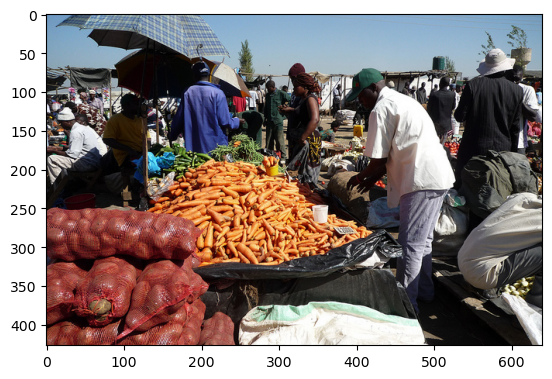

In [17]:
img, mask = get_data_id_image(img_ids[0], coco)

plt.imshow(img)

In [ ]:


mask_generator = SamAutomaticMaskGenerator(sam)



In [31]:
DEVICE ="cpu"

clip_model, preprocess = clip.load("ViT-B/32", device=DEVICE)


In [24]:
result = mask_generator.generate(img)


In [ ]:
objetives = [ "a photo of a " + obj  + " surrounded by dark" for obj in objetives]

text_tokens = clip.tokenize(objetives).to(DEVICE)


for i, mask_dict in enumerate(result[:15]):
    mask = mask_dict["segmentation"]
    
    # Create masked image
    masked_img = np.zeros_like(img)
    masked_img[mask] = img[mask]

    # Convert to PIL and preprocess for CLIP
    pil_image = Image.fromarray(masked_img)
    clip_input = preprocess(pil_image).unsqueeze(0).to(DEVICE)

    # Use CLIP to get caption from visual
    with torch.no_grad():


        image_features, text_features = clip_model.encode_image(clip_input), clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute cosine similarity (logits)
        logits_per_image = image_features @ text_features.T  # shape: (1, len(target_classes))

        # Get raw logits (cosine similarity scores)
        raw_logits = logits_per_image.squeeze(0).cpu().numpy()

        print("probs ass", raw_logits)

    # Plot both masked image and bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Masked Image
    ax1.imshow(masked_img)
    ax1.set_title(f"Segment {i+1}")
    ax1.axis("off")

    # Bar Chart of Probabilities
    ax2.bar(range(len(objetives)), raw_logits, tick_label=objetives)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Probability")
    ax2.set_title("CLIP Predictions")

    plt.tight_layout()
    plt.show()

In [ ]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)



In [ ]:
masks = predictor.generate()


## Usando ClipSeg

In [38]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load the model and processor
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load your image
image = Image.open("your_image.jpg")

# Your natural language prompt
prompt = ["a dog"]

# Preprocess the inputs
inputs = processor(text=prompt, images=[image] * len(prompt), return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# The output is a segmentation map
mask = outputs.logits[0][0].sigmoid()  # 0 to 1 probability mask

# Visualize
plt.imshow(image)
plt.imshow(mask.cpu(), alpha=0.5, cmap='jet')  # overlay mask
plt.axis("off")
plt.show()


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/CIDAS/clipseg-rd64-refined/resolve/main/vocab.json: HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out.
Trying to resume download...


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

ChunkedEncodingError: ('Connection broken: IncompleteRead(194691776 bytes read, 408357720 more expected)', IncompleteRead(194691776 bytes read, 408357720 more expected))